自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，使用自注意力来设计深度架构是很有吸引力的。对比之前仍然依赖循环神经网络实现输入表示的自注意力模型，transformer模型完全基于自注意力机制，没有任何卷积层或循环神经网络层。尽管transformer最初是应用于在文本数据上的序列到序列学习，但现在已经广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

transformer作为编码器-解码器架构的一个实例，其整体架构图如下所示。正如所见到的，transformer是由编码器和解码器组成的。与基于Bahdanau注意力实现的序列到序列的模型相比，transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的嵌入（embedding）编辑欧式将加上位置编码，再分别输入到编码器和解码器中。

![](https://files.mdnice.com/user/23981/1733a53d-4c50-4764-9e05-ec3d3a584851.png)

上图概述了transformer的架构。从宏观角度来看，Transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为sublayer）。第一个子层是多头自注意力（multi-head self-attention）汇聚；第二个子层是基于位置的前馈网络（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受7.6节中残差网络的启发，每个子层都采用了残差连接（residual connection）。在Transformer中, 对于序列中任何位置的任何输入 $\mathbf{x} \in \mathbb{R}^d$, 都要求满足sublayer $(\mathbf{x}) \in \mathbb{R}^d$, 以便残 差连接满足 $\mathbf{x}+\operatorname{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ 。 在残差连接的加法计算之后, 紧接着应用层规范化 (layer normalization）(Ba et al., 2016)。因此, 输入序列对应的每个位置, Transformer编码器都将输出 一个 $d$ 维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为编码器一解码器注意力（encoder-decoder attention）层。在编码器一解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种掩蔽（masked）注意力保留了自回归（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

在此之前已经描述并实现了基于缩放点积多头注意力10.5节和位置编码10.6.3节。接下来将实现Transformer模型的剩余部分。

In [2]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 基于位置的前馈网络

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是基于位置的（positionwise）的原因。在下面的实现中，输入X的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，ffn_num_outputs）的输出张量。

In [9]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""

    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        """
        通过两个全连接层和激活函数的组合，就构成了一个两层的多层感知机结构。在前向传播中，输入张量会经过第一个全连接层、激活函数、第二个全连接层的操作，最终得到输出结果。这个多层感知机结构可以用于在位置上独立地对输入特征进行变换
        """
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


下面的例子显示，改变张量的最里层维度的尺寸，会改变成九月位置的前馈网络的输出尺寸。因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。

基于位置的前馈网络在变换输入时使用了同一个多层感知机（MLP）。这意味着无论输入序列中的哪个位置，它们都会经过相同的变换过程，即使用相同的参数进行计算。因此，当所有位置的输入相同时，它们的输出也是相同的，即输出的尺寸相同。这是因为基于位置的前馈网络是对每个位置的特征进行独立的变换，而不考虑位置之间的关系。

In [8]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))

tensor([[[ 0.5653, -0.2290, -0.3131, -0.2254,  0.0730,  0.3704,  0.4652,
          -0.6138],
         [ 0.5653, -0.2290, -0.3131, -0.2254,  0.0730,  0.3704,  0.4652,
          -0.6138],
         [ 0.5653, -0.2290, -0.3131, -0.2254,  0.0730,  0.3704,  0.4652,
          -0.6138]],

        [[ 0.5653, -0.2290, -0.3131, -0.2254,  0.0730,  0.3704,  0.4652,
          -0.6138],
         [ 0.5653, -0.2290, -0.3131, -0.2254,  0.0730,  0.3704,  0.4652,
          -0.6138],
         [ 0.5653, -0.2290, -0.3131, -0.2254,  0.0730,  0.3704,  0.4652,
          -0.6138]]], grad_fn=<ViewBackward0>)

## 残差连接和层规范化

现在让我们关注 图10.7.1中的加法和规范化（add&norm）组件。正如在本节开头所述，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

7.5节中解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

> 通常, 我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。设全连接层的输入为 $\mathrm{x}$, 权 重参数和偏置参数分别为 $\mathbf{W}$ 和 $\mathbf{b}$, 激活函数为 $\phi$, 批量规范化的运算符为 $\mathrm{BN}$ 。那么, 使用批量规 范化的全连接层的输出的计算详情如下:
$$
\mathbf{h}=\phi(\mathrm{BN}(\mathbf{W} \mathbf{x}+\mathbf{b}))
$$
回想一下，均值和方差是在应用变换的”相同”小批量上计算的。

以下代码对比不同维度的层规范化和批量规范化的效果。

层规范化和批量规范化是深度学习中常用的两种优化技术。它们的作用都是为了提高神经网络模型的训练效果，在不同的场景下选择不同的规范化方法来达到最佳效果。

层规范化是一种在每一层内部进行归一化，使得每一层输出的均值和方差都接近于0和1的操作。这可以有效地减少内部协变量转移（Internal Covariate Shift），即由于每一层输入分布的改变导致网络权重的频繁更新而带来的训练难度。通过对每一层输出进行规范化，层规范化可以加速模型收敛的速度，提高模型的泛化能力。

批量规范化则是在每个批次（Batch）内对输入进行归一化。这种方法通常应用于卷积神经网络（CNN）和循环神经网络（RNN）等结构。批量规范化适用于大规模数据集的情况，并且在对训练样本进行梯度更新时保证稳定性。批量规范化还有一个优点是可以防止梯度消失或爆炸问题的发生，使得模型更加稳定。

两种规范化技术的区别主要在于规范化的位置不同。层规范化是在每个神经网络层内部进行的，而批量规范化是在一个批次内对输入进行归一化。然而，两种规范化技术都可以有效地加速模型的收敛，并提高模型的泛化能力。

此外，它们之间也存在一些联系：批量规范化可以看作是层规范化的一种特殊形式，在训练中将批量大小设置为1即可获得与层规范化类似的效果。同时，批量规范化和层规范化也可以同时应用在神经网络中以获得更好的效果。

In [10]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print("layer norm:", ln(X), "\nbatch norm:", bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以使用残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化方法使用。

In [13]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""

    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

这段代码定义了一个残差连接后进行层规范化（Residual Connection followed by Layer Normalization）的模块。

1. `class AddNorm(nn.Module):`：定义了一个残差连接后进行层规范化的类。

2. `def __init__(self, normalized_shape, dropout, **kwargs):`：初始化方法，接受规范化的形状（`normalized_shape`）和丢弃率（`dropout`）作为参数。

3. `super(AddNorm, self).__init__(**kwargs):`：调用父类的初始化方法。

4. `self.dropout = nn.Dropout(dropout):`：定义一个丢弃层，用于在训练过程中随机丢弃一部分神经元的输出。

5. `self.ln = nn.LayerNorm(normalized_shape):`：定义一个层规范化层，用于对输入进行层规范化操作。

6. `def forward(self, X, Y):`：前向传播方法，接受输入张量 `X` 和残差张量 `Y` 作为参数。

7. `return self.ln(self.dropout(Y) + X):`：将残差张量 `Y` 经过丢弃层和层规范化层的操作后，与输入张量 `X` 相加，然后再经过层规范化操作得到输出结果。

残差连接（Residual Connection）是指在神经网络的某一层中，将输入张量（例如 `X`）直接与经过该层的变换后的张量（例如 `Y`）相加，即 `Y + X`。这种连接方式允许信息在网络中直接流动，避免了深层网络中的梯度消失问题，并且能够更有效地学习表示。

层规范化（Layer Normalization）是一种对输入进行规范化的技术，用于减小不同样本、不同维度的输入之间的差异，使得模型对输入的变化更加鲁棒。它计算输入张量的均值和方差，并对输入进行平移和缩放操作，以使得输出的均值接近0，方差接近1。

在代码中，残差连接通过将输入张量 `X` 与经过丢弃层和层规范化层操作后的残差张量 `Y` 相加来实现。然后，将相加结果输入到层规范化层中，进行层规范化操作。最终得到的输出是经过残差连接和层规范化后的结果。

以下是一个例子来说明残差连接和层规范化的作用：

假设输入张量 `X` 的形状为 (batch_size, hidden_size)，残差张量 `Y` 的形状也为 (batch_size, hidden_size)。在前向传播过程中，首

先将 `Y` 经过丢弃层和层规范化层的操作得到 `Y'`，然后将 `Y'` 与输入张量 `X` 相加得到输出张量 `Z`。这样，输出张量 `Z` 既包含了输入张量 `X` 的信息，又包含了经过变换后的残差张量 `Y'` 的信息。最终的输出张量 `Z` 可以用于后续的网络层或任务。

残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同。

In [14]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 编码器

有了组成Transformer编码器的基础组件，现在可以先实现编码器中的一个层。下面的EncoderBlock类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。

In [18]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

正如从代码中所看到的，Transformer编码器中的任何层都不会改变其输入的形状。

In [19]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

下面实现的transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例。由于这里使用的是值范围在-1和1之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

In [23]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""

    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)  #初始化注意力权重列表，用于存储每个编码器块的注意力权重
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [25]:
[None] * 8

[None, None, None, None, None, None, None, None]

下面我们指定了超参数来创建一个两层的Transformer编码器。 Transformer编码器输出的形状是（批量大小，时间步数目，num_hiddens）。

In [24]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 解码器

如 图10.7.1所示，Transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于序列到序列模型（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。

In [33]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        #自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器-解码器注意力
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

在这段代码中，`X2`表示通过自注意力机制计算得到的结果，而`Y2`表示通过编码器-解码器注意力机制计算得到的结果。这两种注意力机制有以下区别：

1. 自注意力（Self-Attention）：自注意力机制是指在序列中的每个位置上，计算该位置与序列中其他位置的关联性权重。在这里，`self.attention1`表示自注意力机制，它将输入序列`X`作为查询、键和值，计算得到的`X2`表示每个位置对序列其他位置的注意力权重。

2. 编码器-解码器注意力（Encoder-Decoder Attention）：编码器-解码器注意力机制是指在解码器中的每个位置上，计算该位置与编码器中所有位置的关联性权重。在这里，`self.attention2`表示编码器-解码器注意力机制，它将解码器的输入`Y`作为查询，编码器的输出`enc_outputs`作为键和值，计算得到的`Y2`表示解码器位置与编码器输出位置之间的注意力权重。

总的来说，自注意力机制用于捕捉序列内部的关联性，每个位置对序列其他位置进行注意力计算；而编码器-解码器注意力机制用于捕捉编码器和解码器之间的关联性，解码器中的每个位置对编码器输出的所有位置进行注意力计算。这两种注意力机制的区别在于计算的对象和目的不同。

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是num_hiddens。

In [30]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

现在我们构建了由num_layers个DecoderBlock实例组成的完整的Transformer解码器。最后，通过一个全连接层计算所有vocab_size个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。

In [31]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 训练

依照Transformer架构来实例化编码器－解码器模型。在这里，指定Transformer的编码器和解码器都是2层，都使用4头注意力。与9.7.4节类似，为了进行序列到序列的学习，下面在“英语－法语”机器翻译数据集上训练Transformer模型。

loss 0.032, 5981.4 tokens/sec on cuda:0


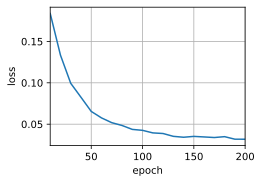

In [35]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用Transformer模型将一些英语句子翻译成法语，并且计算它们的BLEU分数。

In [36]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng,fra in zip(engs,fras):
    translation,dec_atttention_weight_seq=d2l.predict_seq2seq(net,eng,src_vocab,tgt_vocab,
                                                              num_steps,device,True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


当进行最后一个英语到法语的句子翻译工作时，让我们可视化Transformer的注意力权重。编码器自注意力权重的形状为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或“键－值”对的数目）。

In [37]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。